## Seminar 5: Deep Networks

In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import cPickle as pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy.misc import imread, imsave, imresize
from lasagne.utils import floatX

/home/necnec/progs/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.nonlinearities import rectify, softmax

IMAGE_W = 224

#vgg19 model
#http://www.robots.ox.ac.uk/~vgg/research/very_deep/
def build_model():
    net = {}
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_4'] = ConvLayer(net['conv3_3'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_4'], 2)
    net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['conv4_4'] = ConvLayer(net['conv4_3'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_4'], 2)
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['conv5_4'] = ConvLayer(net['conv5_3'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_4'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
    net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=4096)
    net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5)
    net['fc8'] = DenseLayer(net['fc7_dropout'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)
    return net

In [3]:
#classes' names are stored here
classes = pickle.load(open('classes.pkl'))
#for example, 10th class is ostrich:
print classes[:20]

['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark', 'electric ray, crampfish, numbfish, torpedo', 'stingray', 'cock', 'hen', 'ostrich, Struthio camelus', 'brambling, Fringilla montifringilla', 'goldfinch, Carduelis carduelis', 'house finch, linnet, Carpodacus mexicanus', 'junco, snowbird', 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 'robin, American robin, Turdus migratorius', 'bulbul', 'jay', 'magpie', 'chickadee']


You have to implement two functions in the cell below.

Preprocess function should take the image with shape (w, h, 3) and transform it into a tensor with shape (1, 3, 224, 224). Without this transformation, vgg19 won't be able to digest input image. 
Additionally, your preprocessing function have to rearrange channels RGB -> BGR and subtract mean values from every channel.

In [4]:
MEAN_VALUES = np.array([104, 117, 123])
IMAGE_W = 224

def preprocess(img):
    #print img[0,0], imresize(img, (IMAGE_W, IMAGE_W))[0,0]
    return np.transpose(imresize(img, (IMAGE_W, IMAGE_W)), axes=[2, 0, 1])[np.newaxis,::-1] - MEAN_VALUES[np.newaxis,:,np.newaxis,np.newaxis]
    
def deprocess(img):
    return np.transpose((img + MEAN_VALUES[np.newaxis,:,np.newaxis,np.newaxis])[:,::-1], axes=[0, 2, 3, 1])[0]

img = np.random.randint(256, size=(IMAGE_W, IMAGE_W, 3))
if not np.all(deprocess(preprocess(img)) == img):
    print """Either your implementation is incorrect, or floating point arithmetic is pulling some tricks
anyway, the idea is that deprocess function is the inverse of preprocess function"""

In [5]:
#load model weights
#vgg19.npz is available for download at
#https://yadi.sk/d/UQPXeM_GqEmGg
net = build_model()
params = np.load('vgg19.npz')['params']
for i in range(32,len(params)):
    params[i] = params[i].T
lasagne.layers.set_all_param_values(net.values(), params)

In [6]:
input_image = T.tensor4('input')
output = lasagne.layers.get_output(net['prob'], input_image, deterministic=True)
prob = theano.function([input_image], output) 

In the cell below, you can test your preprocessing function on some sample images. If it is implemented correctly, **albatross.jpg** will be classified as albatross with 99.9% certainty, and with other pictures the network will produce mostly meaningful result.

You can notice that network output varies from run to run. This behaviour can be supressed with help of "deterministic" keyword in get_output function in the cell above.

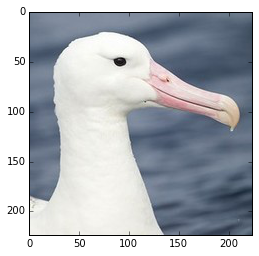

top-5 classes are:
0.998435	albatross
0.001543	goose
0.000007	American egret
0.000006	ptarmigan
0.000002	American coot


In [7]:
img = imread('sample_images/albatross.jpg')
plt.imshow(img)
plt.show()

p = prob(preprocess(img))

labels = p.ravel().argsort()[-1:-6:-1]
print 'top-5 classes are:'
for l in labels:
    print '%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0])

Now, use vgg19 network and your knowledge of machine learning to classify cats and dogs!

data: https://yadi.sk/d/m6ZO4BvWqEmR9

**catsvsdogs/val/** validation images

**catsvsdogs/val_labels.pickle** labels for validation images, sorted by filename

**catsvsdogs/test/** test images

You have to implement classification algorithm, tune it on validation images, save output of your algorithm on test images in form of pickled file, as shown below. Your results, as well as this notebook, have to be attached to your letter to rdlclass@yandex.ru

I expect classification accuracy >95%, or >90% at least

Cheating is not allowed

In [72]:
def classify(img):
    p = prob(preprocess(img))

    labels = p.ravel().argsort()[-1:0:-1]
    for l in labels:
        if p.ravel()[l] < 0.3:
            break
             
        if classes[l].lower().find("cat") != -1:
            #print "cat"
            return "cat"
        
        if classes[l].lower().find("dog") != -1:
            #print "dog"
            return "dog"
        
        if classes[l].lower().find("hound") != -1:
            #print "dog hound"
            return "dog"
        
        if classes[l].lower().find("terrier") != -1:
            #print "dog terrier"
            return "dog"
        
        if classes[l].lower().find("retriever") != -1:
            #print "dog pekinese"
            return "dog"
        
        if classes[l].lower().find("doberman") != -1:
            #print "dog pekinese"
            return "dog"
        
        if classes[l].lower().find("pekinese") != -1:
            #print "dog pekinese"
            return "dog"
        
        if classes[l].lower().find("pomeranian") != -1:
            #print "dog pekinese"
            return "dog"
        
        if classes[l].lower().find("chihuahua") != -1:
            #print "dog griffon"
            return "dog"
        
        if classes[l].lower().find("griffon") != -1:
            #print "dog griffon"
            return "dog"
        
        if classes[l].lower().find("spaniel") != -1:
            #print "dog spaniel"
            return "dog"
        
        if classes[l].lower().find("collie") != -1:
            #print "dog collie"
            return "dog"
        
        if classes[l].lower().find("chow") != -1:
            #print "dog chow"
            return "dog"
        
        if classes[l].lower().find("dhole") != -1:
            #print "dog dhole"
            return "dog"
    #for l in labels[:5]:
    #    print classes[l]
    
    
    #because dog names more special
    return gridsearch.predict(p.ravel())[0]

#### Dummy filter

In [73]:
from sklearn.metrics import accuracy_score
## VALIDATION
labels_val_true = pickle.load(open('catsvsdogs/val_labels.pickle'))

labels_val_pred = []
path = 'catsvsdogs/val/'
files = sorted(os.listdir(path))
for i, f in enumerate(files):
    img = imread(path + f)
    print "IMG: ", f
    label = classify(img)
    labels_val_pred.append(label)
    if labels_val_pred[-1] != labels_val_true[i]:
        print "INCORRECT true:{}, pred:{}".format(labels_val_true[i],labels_val_pred[i])
print "Accuracy: ", accuracy_score(labels_val_true, labels_val_pred)

IMG:  000.jpg
IMG:  001.jpg
IMG:  002.jpg
IMG:  003.jpg
IMG:  004.jpg
IMG:  005.jpg
IMG:  006.jpg
IMG:  007.jpg
IMG:  008.jpg
IMG:  009.jpg
IMG:  010.jpg
IMG:  011.jpg
IMG:  012.jpg
IMG:  013.jpg
IMG:  014.jpg
IMG:  015.jpg
IMG:  016.jpg
IMG:  017.jpg
IMG:  018.jpg
IMG:  019.jpg
IMG:  020.jpg
IMG:  021.jpg
IMG:  022.jpg
IMG:  023.jpg
IMG:  024.jpg
IMG:  025.jpg
IMG:  026.jpg
IMG:  027.jpg
IMG:  028.jpg
IMG:  029.jpg
IMG:  030.jpg
IMG:  031.jpg
IMG:  032.jpg
IMG:  033.jpg
IMG:  034.jpg
IMG:  035.jpg
IMG:  036.jpg
IMG:  037.jpg
IMG:  038.jpg
IMG:  039.jpg
IMG:  040.jpg
IMG:  041.jpg
IMG:  042.jpg
IMG:  043.jpg
IMG:  044.jpg
IMG:  045.jpg
IMG:  046.jpg
IMG:  047.jpg
IMG:  048.jpg
IMG:  049.jpg
IMG:  050.jpg
IMG:  051.jpg
IMG:  052.jpg
IMG:  053.jpg
IMG:  054.jpg
IMG:  055.jpg
IMG:  056.jpg
IMG:  057.jpg
IMG:  058.jpg
IMG:  059.jpg
IMG:  060.jpg
IMG:  061.jpg
IMG:  062.jpg
IMG:  063.jpg
IMG:  064.jpg
IMG:  065.jpg
IMG:  066.jpg
IMG:  067.jpg
IMG:  068.jpg
IMG:  069.jpg
IMG:  070.jpg
IMG:  

#### Random forest

In [23]:
X = []
for f in files:
    img = imread(path + f)
    X.append(prob(preprocess(img)))
X = np.array(X)
y_true = labels_val_true
X = X[:,0,:]


In [66]:
param_grid = {'max_depth':[2,3,4,5,6,7]}
gridsearch = gsc(RandomForestClassifier(), param_grid, cv=20)
gridsearch.fit(X,y_true)
gridsearch.best_score_
y_pred =gridsearch.predict(X)
for i in range(len(y_true)):
    
    if y_pred[i]!=y_true[i]:
        print i

In [67]:
accuracy_score(y_pred, y_true )

1.0

### .

In [74]:
path = 'catsvsdogs/test/'
files = sorted(os.listdir(path))

labels = []

for f in files:
    img = imread(path + f)
    print "IMG: ", f
    label = classify(img)
    labels.append(label)
    
pickle.dump(labels, open('test_labels.pickle', 'wb'))

IMG:  000.jpg
IMG:  001.jpg
IMG:  002.jpg
IMG:  003.jpg
IMG:  004.jpg
IMG:  005.jpg
IMG:  006.jpg
IMG:  007.jpg
IMG:  008.jpg
IMG:  009.jpg
IMG:  010.jpg
IMG:  011.jpg
IMG:  012.jpg
IMG:  013.jpg
IMG:  014.jpg
IMG:  015.jpg
IMG:  016.jpg
IMG:  017.jpg
IMG:  018.jpg
IMG:  019.jpg
IMG:  020.jpg
IMG:  021.jpg
IMG:  022.jpg
IMG:  023.jpg
IMG:  024.jpg
IMG:  025.jpg
IMG:  026.jpg
IMG:  027.jpg
IMG:  028.jpg
IMG:  029.jpg
IMG:  030.jpg
IMG:  031.jpg
IMG:  032.jpg
IMG:  033.jpg
IMG:  034.jpg
IMG:  035.jpg
IMG:  036.jpg
IMG:  037.jpg
IMG:  038.jpg
IMG:  039.jpg
IMG:  040.jpg
IMG:  041.jpg
IMG:  042.jpg
IMG:  043.jpg
IMG:  044.jpg
IMG:  045.jpg
IMG:  046.jpg
IMG:  047.jpg
IMG:  048.jpg
IMG:  049.jpg
IMG:  050.jpg
IMG:  051.jpg
IMG:  052.jpg
IMG:  053.jpg
IMG:  054.jpg
IMG:  055.jpg
IMG:  056.jpg
IMG:  057.jpg
IMG:  058.jpg
IMG:  059.jpg
IMG:  060.jpg
IMG:  061.jpg
IMG:  062.jpg
IMG:  063.jpg
IMG:  064.jpg
IMG:  065.jpg
IMG:  066.jpg
IMG:  067.jpg
IMG:  068.jpg
IMG:  069.jpg
IMG:  070.jpg
IMG:  

## Visualizations

It is easy to visualize the weights of the first convolutional layer:

/home/necnec/progs/anaconda/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


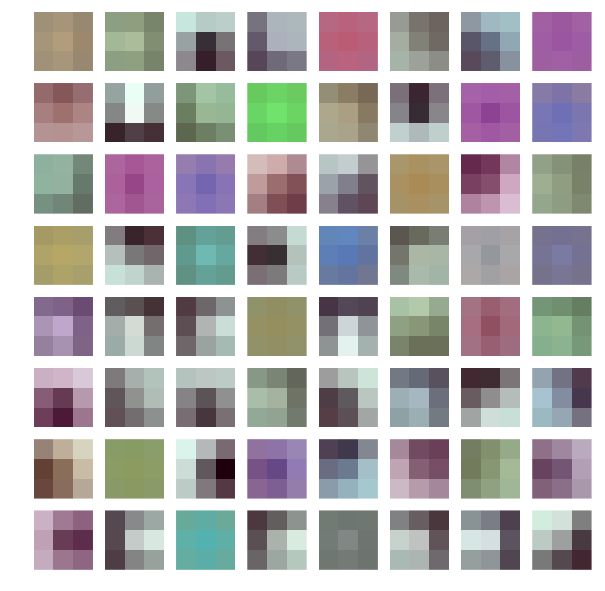

In [75]:
w = net['conv1_1'].W.eval().copy()
w -= w.min()
w /= w.max()
plt.figure(figsize=(10, 10))
for i in range(8):
    for j in range(8):
        n = 8*j + i
        if n < 64:
            plt.subplot(8,8,n)
            plt.axis('off')
            plt.imshow(w[n,:,:,:].transpose((1,2,0)), interpolation='none')
plt.show()

On higher layers, filters have more than 3 channels, so it is impossible to visualize them directly. However, of we want to understand something about features on higher layers, it is possible to visualize them via optimization of the input image.

Namely, we can solve the following problem

$$J=\mathrm{argmax} \left( n^i_{xyc}(I) \right)$$

there $n^i_{xyc}$ is the activation of neuron on $i$'th layer in position $x$,$y$,$c$ given input image $I$.
Basically, $J$ is the answer on a question "what our neuron is looking for?"

In [54]:
generated_image = theano.shared(floatX(np.zeros((1, 3, IMAGE_W, IMAGE_W))))
gen_features = lasagne.layers.get_output(net.values(), generated_image)
gen_features = {k: v for k, v in zip(net.keys(), gen_features)}

layer_name = 'pool1'
c = 0
blob_width = gen_features[layer_name].shape[2]
x = blob_width/2
y = blob_width/2
loss = 1e10*(1e1 - gen_features[layer_name][0, c, x, y])**2

grad = T.grad(loss, generated_image)

tv_loss = T.mean(T.abs_(generated_image[:,:,1:,1:] - generated_image[:,:,:-1,1:]) +
                 T.abs_(generated_image[:,:,1:,1:] - generated_image[:,:,1:,:-1]))

f_loss = theano.function([], loss + 1.0 * tv_loss)
f_grad = theano.function([], grad)

# Helper functions to interface with scipy.optimize
def eval_loss(x0):
    x_ = floatX(x0.reshape((1, 3, IMAGE_W, IMAGE_W)))
    generated_image.set_value(x_)
    return f_loss().astype('float64')

def eval_grad(x0):
    x0 = floatX(x0.reshape((1, 3, IMAGE_W, IMAGE_W)))
    generated_image.set_value(x0)
    return np.array(f_grad()).flatten().astype('float64')

/home/necnec/.local/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.
/home/necnec/.local/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.


In [55]:
#run input image optimization via scipy.optimize.fmin_l_bfgs_b
generated_image.set_value(floatX(np.zeros((1, 3, IMAGE_W, IMAGE_W))))
x0 = generated_image.get_value().astype('float64')
status = scipy.optimize.fmin_l_bfgs_b(eval_loss, x0.flatten(), fprime=eval_grad, maxfun=20)
x0 = generated_image.get_value().astype('float64')

If your **deprocess** function is implemented correctly, you'll see that the neuron on the first pooling layer is looking for. The result should look like gabor filter, simular to ones found in the first layer of networks with large filters, such as AlexNet.

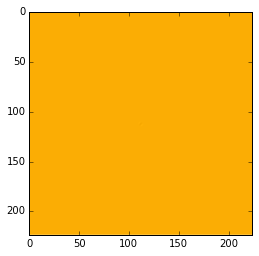

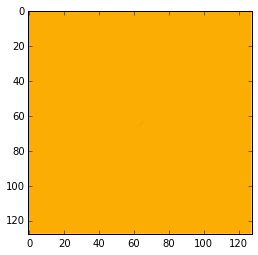

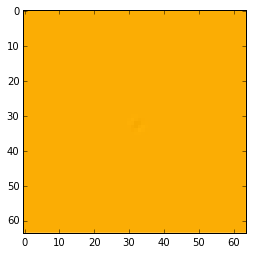

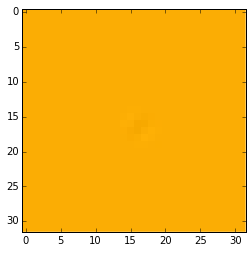

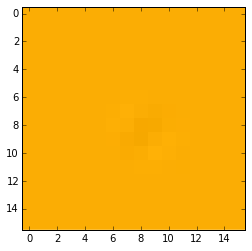

In [56]:
#show the results
w = IMAGE_W
for d in [112, 64, 32, 16, 8]:
    pic = deprocess(x0)[w/2-d:w/2+d,w/2-d:w/2+d,:]
    pic -= pic.min()
    pic /= pic.max()
    plt.imshow(pic, interpolation='None')
    plt.show()

Optional problem:
Adjust the code above to work with neurons on fc8 layer.


fc8 neurons are wired to output classes, so maximization of neuron value will produce an image which contains as much of given class (from the point of view of neural network) as possible. 

Examples of such images are shown at:

http://yosinski.com/deepvis

http://googleresearch.blogspot.ru/2015/06/inceptionism-going-deeper-into-neural.html

http://auduno.com/post/125362849838/visualizing-googlenet-classes